In [1]:
from src.mopso import *
from src.repository.encoding import RealEncoding
from src.Problems.dtlz import Dtlz
from src.repository.mutation import PolynomialM
from src.repository.selection import BinaryTSMO
from src.indicators import *
import pandas as pd


In [2]:
def plot_single_view(ax, front, objectives, labels, title):
    x = []
    y = []
    z = []
    for solution in front:
        objective_values = objectives(solution.value)
        x.append(objective_values[0])
        y.append(objective_values[1])
        z.append(objective_values[2])

    ax.scatter(x, y, z, marker='o', label=f'Front {len(front)}')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.set_title(title)
    ax.legend()

def plot_pareto_front_3d(front, objectives, title="Pareto-optimal Front", labels=None, m=3):
    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(131, projection='3d')
    plot_single_view(ax1, front, objectives, labels, title)

    ax2 = fig.add_subplot(132, projection='3d')
    plot_single_view(ax2, front, objectives, labels, title)
    ax2.view_init(elev=20, azim=30)  # Set custom viewing angles

    ax3 = fig.add_subplot(133, projection='3d')
    plot_single_view(ax3, front, objectives, labels, title)
    ax3.view_init(elev=45, azim=-30)  # Set custom viewing angles

    #display(fig)

In [3]:

dtlz1 =Dtlz(1)
dtlz2 = Dtlz(2)
dtlz5 = Dtlz(5)
dtlz7 = Dtlz(7)

idtlz1 =Dtlz(1,True)
idtlz2 = Dtlz(2,True)
idtlz5 = Dtlz(5,True)
idtlz7 = Dtlz(7,True)


config_1 = Config(n_var=dtlz1.n,n_iter=200,n_pop=250,c1=3,c2=1,w=6,n_neighborhoods=65)
config_2 = Config(n_var=dtlz2.n,n_iter=100,n_pop=250,c1=0.4,c2=1.8,w=5,n_neighborhoods=10)
config_5 = Config(n_var=dtlz5.n,n_iter=200,n_pop=150,c1=0.3,c2=0.7,w=7,n_neighborhoods=100)
config_7 = Config(n_var=dtlz7.n,n_iter=70,n_pop=300,c1=0.3,c2=0.7,w= 3,n_neighborhoods=4)

mutation_1 = PolynomialM(0.3,0.3)
mutation_2 = PolynomialM(0.8,0.2)
mutation_5 = PolynomialM(0.5,0.10)
mutation_7 = PolynomialM(0.5,0.9)

real_encoding_1 = RealEncoding(bounds=dtlz1.bounds)
real_encoding_2 = RealEncoding(bounds=dtlz2.bounds)
real_encoding_5 = RealEncoding(bounds=dtlz5.bounds)
real_encoding_7 = RealEncoding(bounds=dtlz7.bounds)



selection = BinaryTSMO()

problems = [(dtlz1,config_1,real_encoding_1,mutation_1),(dtlz2,config_2,real_encoding_2,mutation_2),(dtlz5,config_5,real_encoding_5,mutation_5),(dtlz7,config_7,real_encoding_7,mutation_7)
            ,(idtlz1,config_1,real_encoding_1,mutation_1),(idtlz2,config_2,real_encoding_2,mutation_2),(idtlz5,config_5,real_encoding_5,mutation_5),(idtlz7,config_7,real_encoding_7,mutation_7)]


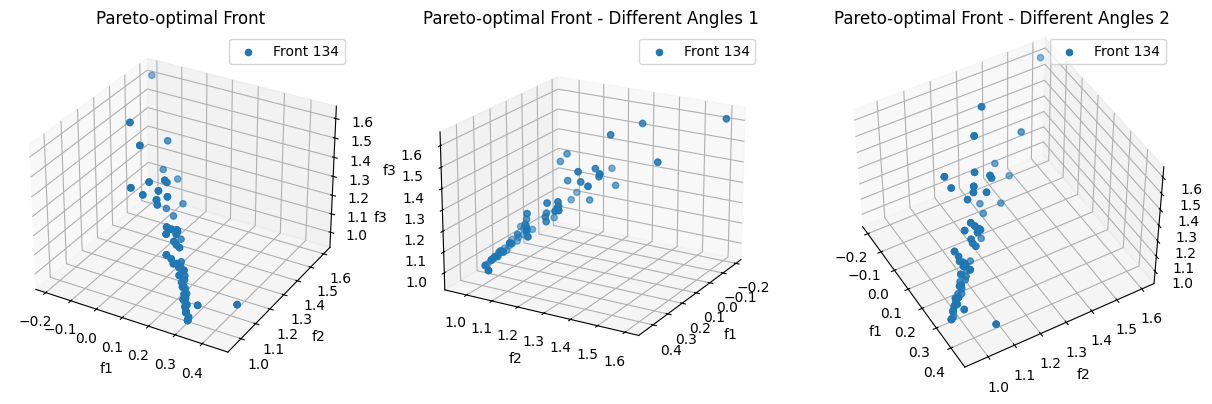

In [4]:
results = {}

for i in range(30):
    print(i+1)

    for problem,config,encoding,mutation in problems:
        print(problem.name)
        mopso = MOPSO(encoding=encoding,config=config,mutation=mutation,selection=selection)
        result = mopso.run(problem.evaluate,True)
        try:
            results[problem.name].append(result)
        except KeyError:

            results[problem.name] = []
            results[problem.name].append(result)



In [7]:
df_results = {}

for prob,_,_,_ in problems:
    r2_values = []
    se_values = []
    for i, front in enumerate(results[prob.name]):
        values = [ind.fitness for ind in front]
        r2 = r2_indicator(values, prob.z)
        se = calculate_s_energy(values)
        r2_values.append(r2)
        se_values.append(se)

    df_results[prob.name] = {'r2': r2_values, 'se': se_values}

df = pd.concat({k: pd.DataFrame(v) for k, v in df_results.items()}, axis=1)
df.tail()


dtlz1                  dtlz2                  dtlz5                \
          r2           se        r2           se        r2            se   
21  3.529997  1318.503870  0.201251  3953.021882  0.725640  70360.904483   
22  3.543210  1381.297845  0.217011  3952.557032  0.727168  81658.709814   
23  3.477991  1393.526676  0.213266  5994.448286  0.726990  74763.400229   
24  3.515530  1326.686254  0.200743  2262.034070  0.728657  66102.306313   
25  3.521671  1321.984737  0.200183  4435.888577  0.724295  68566.420482   

       dtlz7                   idtlz1                 idtlz2                \
          r2            se         r2           se        r2            se   
21  0.838101  1.029857e+06  11.784796  1432.262377 -0.098975  23506.590670   
22  0.843208  8.722037e+05  11.775065  1296.074904 -0.101826  45802.369951   
23  0.843248  5.602844e+06  11.771475  1333.573924 -0.099418  33378.851920   
24  0.842489  4.845201e+07  11.760251  1377.218059 -0.098763  22971.249602   
25       NaN           NaN        NaN          NaN       NaN           NaN   

      idtlz5                 idtlz7               
          r2           se        r2           se  
21 -0.069048  1848.906608  0.576331   219.854647  
22 -0.084090  4098.921546  0.372164  2096.789152  
23 -0.066799   795.295307  0.333757   414.358996  
24 -0.083711  2251.615042  0.760831     3.886284  
25       NaN          NaN       NaN          NaN

In [8]:
def find_closest_to_mean(df):
    closest_to_mean = {}
    for problem in df.columns.levels[0]:
        mean_r2 = df[problem, 'r2'].mean()
        absolute_difference_function = lambda list_value : abs(list_value - mean_r2)
        closest_value = min(df[problem, 'r2'].tolist(), key=absolute_difference_function)
        closest_to_mean[problem] = df[problem, 'r2'][df[problem, 'r2'] == closest_value].index[0]
    return closest_to_mean

res = find_closest_to_mean(df)


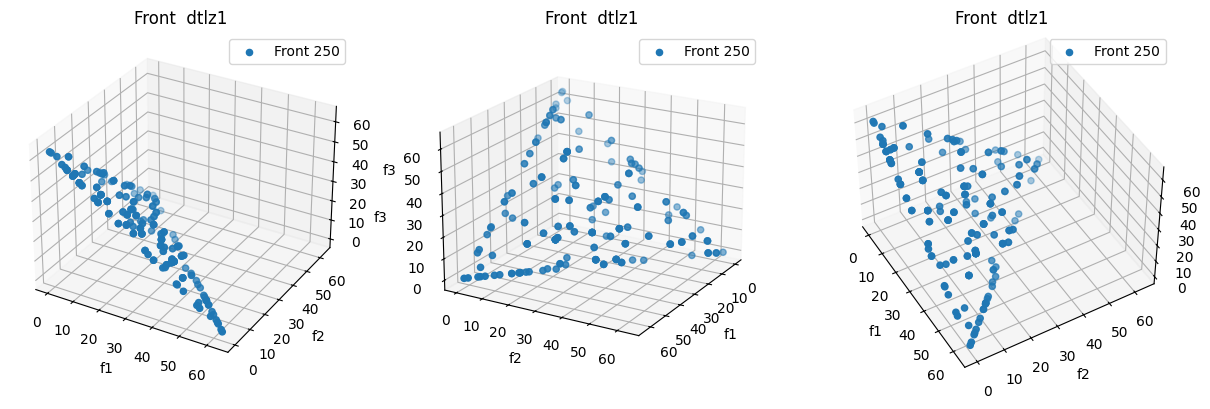

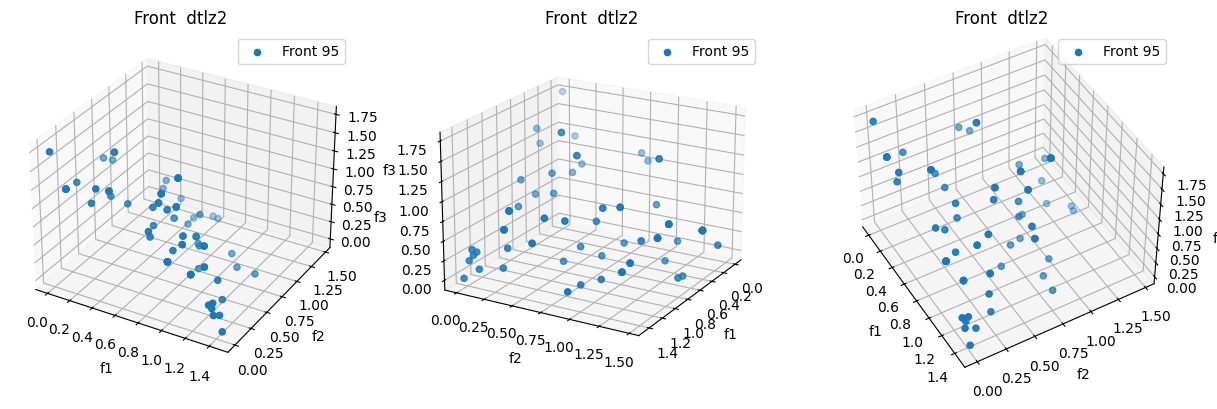

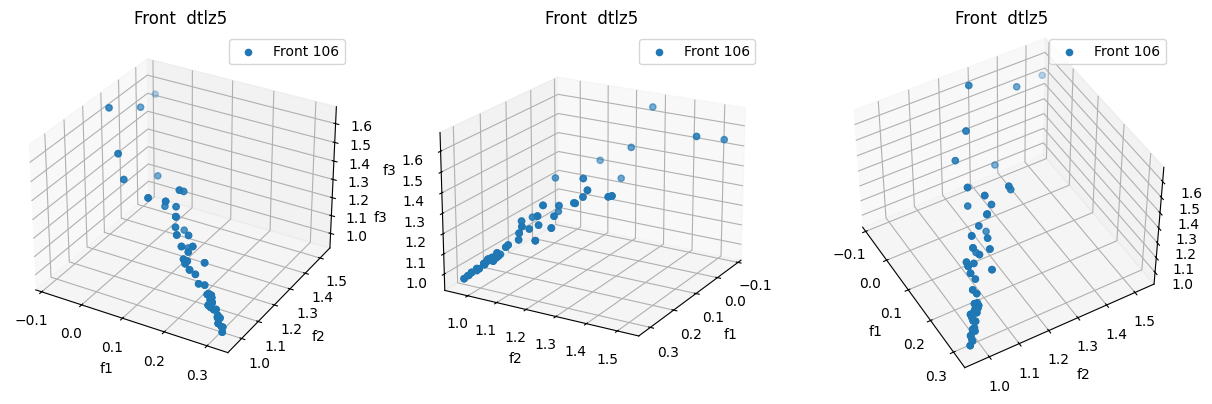

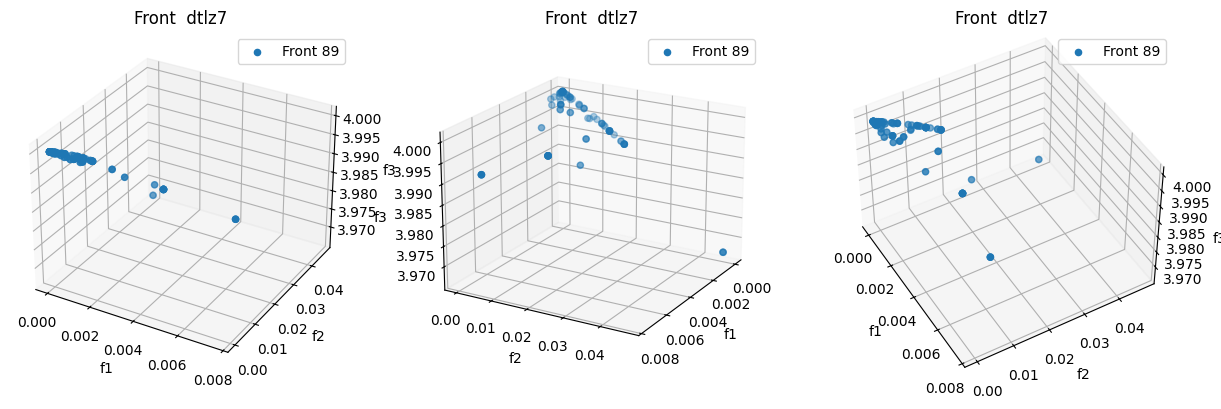

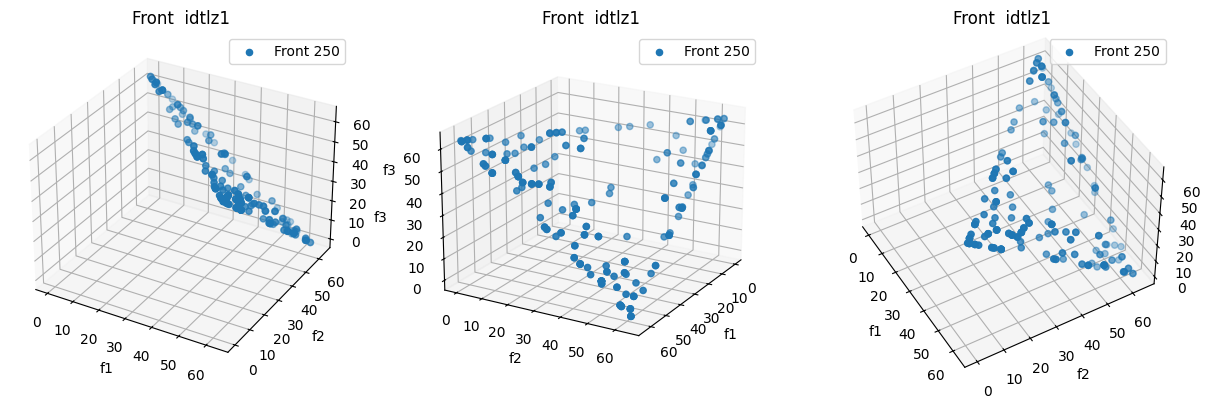

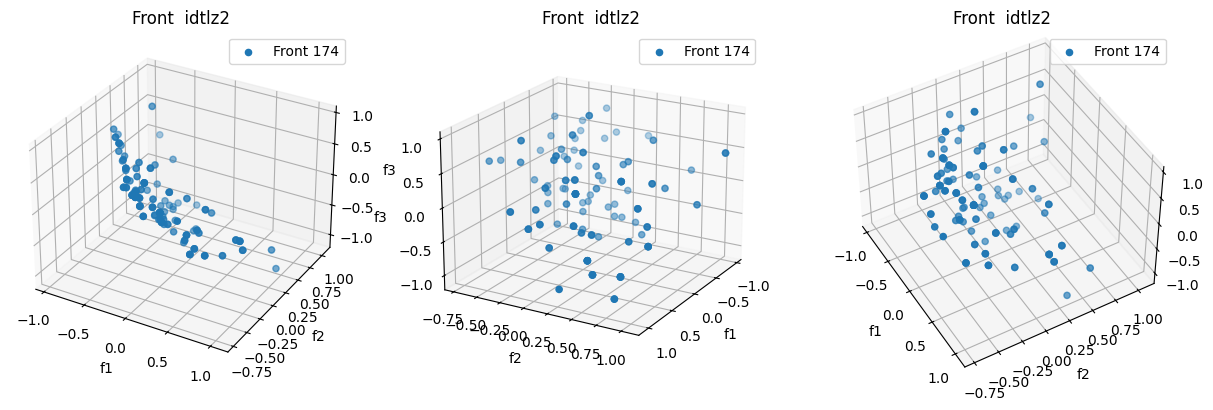

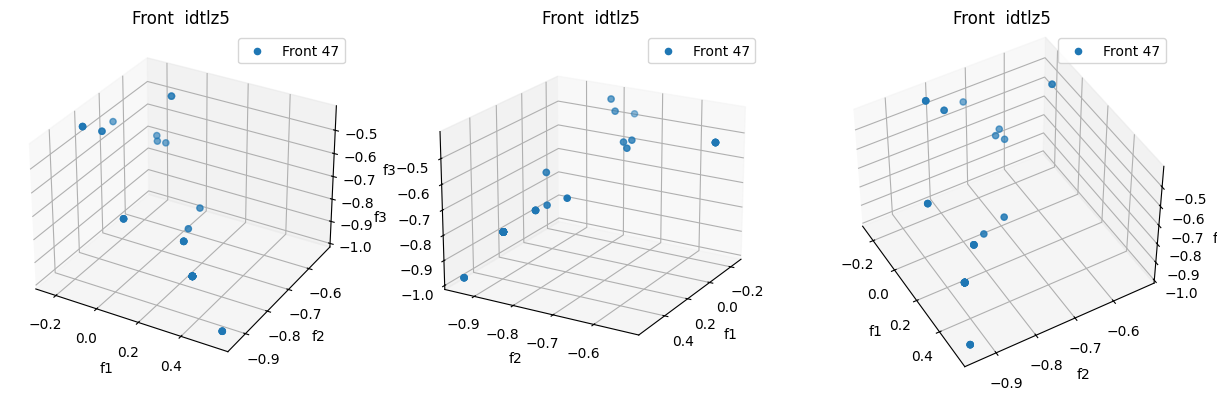

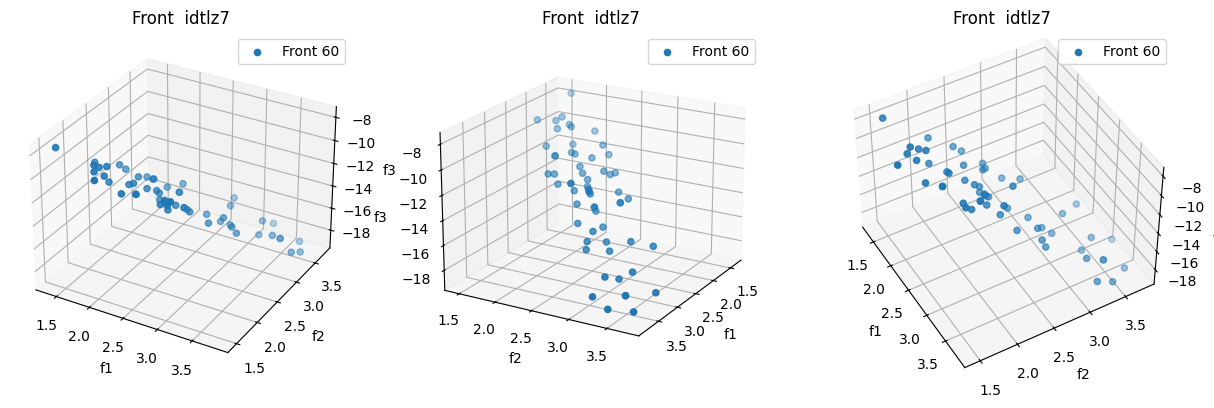

In [9]:
for problem,_,_,_ in problems:
    i = res[problem.name]
    plot_pareto_front_3d(results[problem.name][i], problem.evaluate, title="Front "+' '+problem.name, labels=['f1','f2','f3'])
